In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

In [89]:
# Classification: Can we predict whether a particular car model will be a "best-seller" (yes/no) based on
# features, historical sales data, and marketing efforts.
file_path = "../data/processed/car_sales_data_with_synthetic_features.csv"
df = pd.read_csv(file_path)

df.head(3)

,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region,Mileage_km_total,Crash_Test_Score,Family_Size
0,C_CND_000001,1/2/2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown,68468,4,2
1,C_CND_000002,1/2/2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora,64053,3,2
2,C_CND_000003,1/2/2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville,24942,5,3


In [90]:
# Extract year and month from the 'date' column
df["Date"] = pd.to_datetime(df["Date"])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# Combine company and model into a single 'Model' column
df["Full_Model"] = df["Company"] + " " + df["Model"]

# Select relevant features for classification
features = [
    "year",
    "month",
    "Full_Model",
    "Engine",
    "Transmission",
    "Color",
    "Body Style",
    "Mileage_km_total",
    "Crash_Test_Score",
]

df = df[features]

# Rename columns for clarity
df2 = df.rename(
    columns={
        "Full_Model": "full_model",
        "Engine": "engine",
        "Transmission": "transmission",
        "Color": "color",
        "Body Style": "body_style",
        "Mileage_km_total": "mileage_km",
        "Crash_Test_Score": "crash_test_score",
    }
)

# Parse types of features
df2 = df2.astype(
    {
        "year": "int",
        "month": "int",
        "crash_test_score": "int",
        "mileage_km": "int",
    }
)

print(df2.info())
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              23906 non-null  int64 
 1   month             23906 non-null  int64 
 2   full_model        23906 non-null  object
 3   engine            23906 non-null  object
 4   transmission      23906 non-null  object
 5   color             23906 non-null  object
 6   body_style        23906 non-null  object
 7   mileage_km        23906 non-null  int64 
 8   crash_test_score  23906 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.6+ MB
None


,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4


In [91]:
# Add a new feature to indicate if the car model is a best-seller
# For simplicity, let's assume a model is a best-seller if it is in top 3 models sold in a given year and month.

# Aggregate by year, month, and full_model to get total number of sales
df2_agg = (
    df2.groupby(["year", "month", "full_model"])["year"].count().reset_index(name="current_month_sales")
)

# Add sales of N previous months
df2_agg = df2_agg.sort_values(by=["full_model", "year", "month"])
for i in range(1, 13):
    df2_agg[f"last_{i}_months_sales"] = (
        df2_agg.groupby(["full_model"])["current_month_sales"]
        .rolling(window=i, min_periods=1)
        .sum()
        .reset_index(level=0, drop=True)
    )

# Find rank of each full_model within a year and a month based on current_month_sales
df2_agg["rank"] = df2_agg.groupby(["year", "month"])["current_month_sales"].rank(
    method="first", ascending=False
)
df2_agg["monthly_best_seller"] = (df2_agg["rank"] <= 3).astype(int)
df2_agg.drop(columns=["rank"], inplace=True)

# Merge the aggregated data back to the original DataFrame
df3 = df2.merge(df2_agg, on=["year", "month", "full_model"], how="left")

df3.head()

,year,month,full_model,engine,transmission,color,body_style,mileage_km,crash_test_score,current_month_sales,...,last_4_months_sales,last_5_months_sales,last_6_months_sales,last_7_months_sales,last_8_months_sales,last_9_months_sales,last_10_months_sales,last_11_months_sales,last_12_months_sales,monthly_best_seller
0,2022,1,Ford Expedition,DoubleÂ Overhead Camshaft,Auto,Black,SUV,68468,4,2,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0
1,2022,1,Dodge Durango,DoubleÂ Overhead Camshaft,Auto,Black,SUV,64053,3,3,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0
2,2022,1,Cadillac Eldorado,Overhead Camshaft,Manual,Red,Passenger,24942,5,6,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,1
3,2022,1,Toyota Celica,Overhead Camshaft,Manual,Pale White,SUV,108673,3,4,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0
4,2022,1,Acura TL,DoubleÂ Overhead Camshaft,Auto,Red,Hatchback,51660,4,4,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0


In [92]:
# Prepare data for model training and testing

test_cond = (df3["year"] == 2023) & (df3["month"] >= 10)
train_df = df3[~test_cond]
test_df = df3[test_cond]
X_train = train_df.drop(columns=["monthly_best_seller"])
y_train = train_df["monthly_best_seller"]
X_test = test_df.drop(columns=["monthly_best_seller"])
y_test = test_df["monthly_best_seller"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

dist = np.bincount(y_train)
print("\nClass distribution:", dist)
print("First class:", 100 - dist[1] / dist[0] * 100)
print("Second class:", dist[1] / dist[0] * 100)

Shapes:
(19140, 22) (19140,)
(4766, 22) (4766,)

Class distribution: [17935  1205]
First class: 93.28129356007805
Second class: 6.71870643992194


In [93]:
numeric_features = [
    "year",
    "month",
    "mileage_km",
    "crash_test_score",
    "current_month_sales",
    *[f"last_{i}_months_sales" for i in range(1, 13)],
]
categorical_features = ["full_model", "engine", "transmission", "color", "body_style"]
weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = dict(zip(np.unique(y_train), weights))

In [ ]:
def grid_search_pipeline(pipeline, extra_params: dict = None):
    param_grid = {
        # OneHotEncoder hyperparameters
        "preprocessor__cat__onehot__drop": [
            "first",
            None,
        ],  # Drop first column to avoid collinearity
    }
    if extra_params is not None:
        param_grid.update(extra_params)
    grid = GridSearchCV(pipeline, param_grid, scoring="f1", cv=5)
    grid.fit(X_train, y_train)

    print("Best params:", grid.best_params_)
    print("Best AUC:", grid.best_score_)
    return grid.best_estimator_

In [95]:
def evaluate_model(model):
    y_pred = model.predict(X_test)

    # Predict probabilities (for ROC, AUC, etc.)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [96]:
preprocessor = ColumnTransformer(
    [
        ("num", Pipeline([("scaler", StandardScaler())]), numeric_features),
        (
            "cat",
            Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]),
            categorical_features,
        ),
    ]
)

In [97]:
pipeline_1 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, class_weight=class_weights)),
    ]
)
pipeline_1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_months_sales',
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['full_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 0.5335935321996097,
                                                  1: 7.941908713692946},
                                    max_iter=1000))])

In [98]:
from sklearn.ensemble import RandomForestClassifier

pipeline_2 = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier()),
    ]
)
pipeline_2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_months_sales',
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['full_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style'])])),
                ('classifier', RandomForestClassifier())])

In [99]:
from xgboost import XGBClassifier

pipeline_3 = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        ),
    ]
)
pipeline_3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_m...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [100]:
from lightgbm import LGBMClassifier

pipeline_4 = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            LGBMClassifier(verbose=-1, random_state=42),
        ),
    ]
)
pipeline_4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'month',
                                                   'mileage_km',
                                                   'crash_test_score',
                                                   'current_month_sales',
                                                   'last_1_months_sales',
                                                   'last_2_months_sales',
                                                   'last_3_months_sales',
                                                   'last_4_months_sales',
                                                   'last_5_months_sales',
                                                   'last_6_months_sales',
                                                   'last_7_months_sales',
                                                   'last_8_months_sales',
                                                   'last_9_months_sales',
                                                   'last_10_months_sales',
                                                   'last_11_months_sales',
                                                   'last_12_months_sales']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['full_model', 'engine',
                                                   'transmission', 'color',
                                                   'body_style'])])),
                ('classifier', LGBMClassifier(random_state=42, verbose=-1))])

Best params: {'classifier__class_weight': None, 'preprocessor__cat__onehot__drop': 'first'}
Best AUC: 0.5760092612486173
Accuracy: 0.9576164498531263
Precision: 0.631578947368421
Recall: 0.6498194945848376
F1 Score: 0.6405693950177936
AUC: 0.9748498736984831


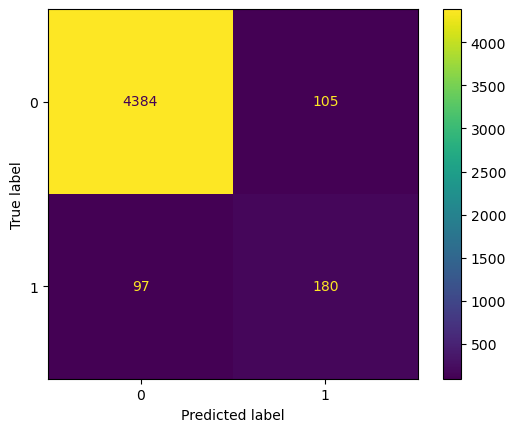

In [ ]:
model_1 = grid_search_pipeline(
    pipeline_1,
    # extra_params={
    #     "classifier__C": [0.01, 0.1, 1, 100],
    #     "classifier__penalty": ["l2", "elasticnet"],
    #     "classifier__solver": ["liblinear", "lbfgs"],
    #     "classifier__fit_intercept": [True, False],
    #     "classifier__class_weight": [class_weights, "balanced", None],
    #     "classifier__l1_ratio": [None, 0.25, 0.5, 0.75],
    # },
    extra_params={
        # LogisticRegression hyperparameters
        "classifier__class_weight": [class_weights, "balanced", None],
        "classifier__penalty": ["l1", "l2", "elasticnet"],
        "classifier__C": [0.01, 0.1, 1.0, 10.0],
        "classifier__solver": ["liblinear", "saga", "lbfgs"],
        "classifier__l1_ratio": [None, 0.25, 0.5, 0.75],  # Only used with elasticnet
        "classifier__fit_intercept": [True, False],
        # OneHotEncoder options
        "preprocessor__cat__onehot__drop": [None, "first"],
        "preprocessor__cat__onehot__sparse_output": [
            False
        ],  # Needed for dense matrix ops
        "preprocessor__cat__onehot__min_frequency": [None, 5],
        "preprocessor__cat__onehot__max_categories": [None, 20, 50],
        # StandardScaler options (less critical but tunable)
        "preprocessor__num__scaler__with_mean": [True],
        "preprocessor__num__scaler__with_std": [True],
    },
)
evaluate_model(model_1)

In [ ]:
model_2 = grid_search_pipeline(
    pipeline_2,
    extra_params={
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__class_weight": [None, "balanced", class_weights],
    },
)
evaluate_model(model_2)

In [ ]:
model_3 = grid_search_pipeline(
    pipeline_3,
    extra_params={
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [3, 6, 10],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__subsample": [0.8, 1],
        "classifier__colsample_bytree": [0.8, 1],
        "classifier__scale_pos_weight": [1, 3],  # if imbalance
    },
)
evaluate_model(model_3)

In [ ]:
model_4 = grid_search_pipeline(
    pipeline_4,
    extra_params={
        "classifier__n_estimators": [100, 300],
        "classifier__learning_rate": [0.01, 0.1],
        "classifier__num_leaves": [15, 31, 63],
        "classifier__max_depth": [-1, 10],
        "classifier__min_child_samples": [10, 20],
        "classifier__subsample": [0.8, 1],
        "classifier__colsample_bytree": [0.8, 1],
    },
)
evaluate_model(model_4)

In [ ]:
import pickle

def dump_model(model, filename):
    with open(filename, "wb") as f:
        pickle.dump(model, f)

def load_model(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


# dump_model(model=None, filename="../model/model.pkl")
# Load with
# load_model(filename="../model/model.pkl")